# `l2hmc-qcd`

This notebook contains a minimal working example for the 4D SU(3) Model

Uses `torch.complex128` by default

## Setup

In [1]:
! nvidia-smi | tail --lines -7

+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    2   N/A  N/A   3789798      C   ...PU/2023-04-26/bin/python3    11895MiB |
+-----------------------------------------------------------------------------+


In [2]:
import lovely_tensors as lt

# automatically detect and reload local changes to modules
%load_ext autoreload
%autoreload 2
lt.monkey_patch()
lt.set_config(color=False)

In [3]:
import os
# --------------------------------------
# BE SURE TO GRAB A FRESH GPU !
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
#!echo $CUDA_VISIBLE_DEVICES
# --------------------------------------

In [4]:
#devices = os.environ.get('CUDA_VISIBLE_DEVICES', None)
#print(devices)
# get number of available CPUs
!getconf _NPROCESSORS_ONLN

256


In [5]:
from __future__ import absolute_import, print_function, annotations, division

import warnings

import torch
import numpy as np

from hydra.core.global_hydra import GlobalHydra

warnings.filterwarnings('ignore')

os.environ['MASTER_PORT'] = '12345'
#os.environ['OMP_NUM_THREADS'] = '256'

np.set_printoptions(threshold=5)
torch.set_printoptions(threshold=5, precision=5)

In [6]:
from l2hmc.utils.dist import (
    setup_torch
)
_ = setup_torch(
    precision='float64',
    backend='DDP',
    seed=1234,
)

--------------------------------------------------------------------------

  Local host:   thetagpu23
  Local device: mlx5_0
--------------------------------------------------------------------------


[06/09/23 16:54:43][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/09/23 16:54:43][WARNING][dist.py:332] - Setting default dtype: float64
[06/09/23 16:54:43][INFO][dist.py:338] - Global Rank: 0 / 0


In [7]:
from l2hmc.experiment.pytorch.experiment import Experiment as ptExperiment

import l2hmc.group.su3.pytorch.group as gpt
ptsu3 = gpt.SU3()

import l2hmc
l2hmc.__file__

2023-06-09 16:54:43.690920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/lus/grand/projects/DLHMC/foremans/locations/thetaGPU/projects/l2hmc-qcd/src/l2hmc/__init__.py'

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt

from l2hmc.common import grab_tensor, print_dict
from l2hmc.utils.plot_helpers import set_plot_style

set_plot_style()

from l2hmc.utils.plot_helpers import (  # noqa
    set_plot_style,
    plot_scalar,
    plot_chains,
    plot_leapfrogs
)


def plot_metrics(metrics: dict, title: Optional[str] = None):
    for key, val in metrics.items():
        fig, ax = plot_metric(val, name=key)
        if title is not None:
            ax.set_title(title)


def plot_metric(
        metric: torch.Tensor,
        name: Optional[str] = None,
):
    assert len(metric) > 0
    if isinstance(metric[0], (int, float, bool, np.floating)):
        y = np.stack(metric)
        return plot_scalar(y, ylabel=name)
    element_shape = metric[0].shape
    if len(element_shape) == 2:
        y = grab_tensor(torch.stack(metric))
        return plot_leapfrogs(y, ylabel=name)
    if len(element_shape) == 1:
        y = grab_tensor(torch.stack(metric))
        return plot_chains(y, ylabel=name)
    if len(element_shape) == 0:
        y = grab_tensor(torch.stack(metric))
        return plot_scalar(y, ylabel=name)
    raise ValueError

## Helper Functions

In [9]:
# backward hook with module name
def get_backward_hook(module_name: str):
    class BackwardHook:
        name: str
        def __init__(self, name):
            self.name = name
        def __call__(self, module, grad_input, grad_output):
            for i, g_in in enumerate(grad_input):
                print(module_name, torch.any(torch.isnan(g_in)))
                if torch.any(torch.isnan(g_in)):
                    print(f"{module_name}'s {i}th input gradient is nan")
            for i, g_out in enumerate(grad_output):
                if torch.any(torch.isnan(g_out)):
                    print(f"{module_name}'s {i}th output gradient is nan")
    return BackwardHook(module_name)

import torch
from torchview import draw_graph

from l2hmc.trainers.pytorch.trainer import Trainer  # noqa
def print_weights(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v for k, v in trainer.dynamics.named_parameters()
    })


def print_grads(trainer: Trainer, grab: bool = True):
    _ = print_dict({
        k: v.grad for k, v in trainer.dynamics.named_parameters()
    })


def print_grads_and_weights(trainer: Trainer, grab: bool = True):
    print(80 * '-')
    print('GRADS:')
    print_grads(trainer)
    print(80 * '-')
    print('WEIGHTS:')
    print_weights(trainer)
    print(80 * '-')


def calc_loss(
        x: torch.Tensor,
        y: torch.Tensor,
        acc: torch.Tensor
) -> torch.Tensor:
    dx = (x - y)
    dx2 = (dx.real.pow(2) + dx.imag.pow(2)).flatten(1)
    return (acc * dx2.mean(1)).sum()


def train_step(
        x: torch.Tensor,
        beta: float | torch.Tensor,
        trainer: Trainer,
) -> tuple[torch.Tensor, dict]:
    if isinstance(beta, float):
        beta = torch.tensor(beta)
    x.requires_grad_(True)
    trainer.optimizer.zero_grad()
    xout, metrics = trainer.dynamics_engine((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-6),
    )
    trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)
    #loss = trainer.backward_step(loss)
    #dx = (x - xprop).abs().flatten(1).mean(-1)
    #loss = (metrics['acc'] * dx).mean()
    #loss = trainer.calc_loss(
    #    xinit=x,
    #    xprop=xprop,
    #    acc=metrics['acc']
    #)
    return xout.detach(), metrics

## Specify defaults for building Experiment

In [10]:
GlobalHydra.instance().clear()

In [12]:
DEFAULTS = {
    'save': False,
    'restore': False,
    'init_aim': False,
    'init_wandb': False,
    'use_wandb': False,
    'use_tb': False,
    'backend': 'DDP',
    'framework': 'pytorch',
    'conv': 'none',
    'network': {
        'use_batch_norm': False,
        'activation_fn': 'tanh',
        'dropout_prob': 0.0,
        'units': [1],
    },
    'dynamics': {
        'group': 'SU3',
        'eps': 0.1,
        'nchains': 2,
        'nleapfrog': 2,
        'verbose': True,
        'latvolume': [4, 4, 4, 4],
        'eps_fixed': False,
    },
    'net_weights': {
        'x': {
            's': 0.0,  # NOTE: No sx term for 4D SU(3) model [currently]
            't': 1.0,
            'q': 1.0,
        },
        'v': {
            's': 1.0,
            't': 1.0,
            'q': 1.0,
        },
    },
    'loss': {
        'rmse_weight': 1.0,
        'plaq_weight': 0.0,
        'charge_weight': 0.0,
        'use_mixed_loss': False,
    },
    'steps': {
        'nera': 1,
        'nepoch': 10,
        'test': 50,
        'print': 1,
        'log': 1,
    },
    'learning_rate': {
        'lr_init': 0.00001,
        'clip_norm': 1.0,
    },
    'annealing_schedule': {
        'beta_init': 6.0,
        'beta_final': 6.0,
    },
}

In [13]:
try:
    import gc
    import GPUtil

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    torch.clear_autocast_cache()
    GPUtil.showUtilization()
except ImportError:
    pass

## Build Experiment

In [14]:
from l2hmc.configs import dict_to_list_of_overrides
OVERRIDES = dict_to_list_of_overrides(DEFAULTS)
OVERRIDES

['save=False',
 'restore=False',
 'init_aim=False',
 'init_wandb=False',
 'use_wandb=False',
 'use_tb=False',
 'backend=DDP',
 'framework=pytorch',
 'conv=none',
 'network.use_batch_norm=False',
 'network.activation_fn=tanh',
 'network.dropout_prob=0.0',
 'network.units=[1]',
 'dynamics.group=SU3',
 'dynamics.eps=0.1',
 'dynamics.nchains=2',
 'dynamics.nleapfrog=2',
 'dynamics.verbose=True',
 'dynamics.latvolume=[4, 4, 4, 4]',
 'dynamics.eps_fixed=False',
 'net_weights.x.s=0.0',
 'net_weights.x.t=1.0',
 'net_weights.x.q=1.0',
 'net_weights.v.s=1.0',
 'net_weights.v.t=1.0',
 'net_weights.v.q=1.0',
 'loss.rmse_weight=1.0',
 'loss.plaq_weight=0.0',
 'loss.charge_weight=0.0',
 'loss.use_mixed_loss=False',
 'steps.nera=1',
 'steps.nepoch=10',
 'steps.test=50',
 'steps.print=1',
 'steps.log=1',
 'learning_rate.lr_init=1e-05',
 'learning_rate.clip_norm=1.0',
 'annealing_schedule.beta_init=6.0',
 'annealing_schedule.beta_final=6.0']

In [15]:
from l2hmc.configs import get_experiment  # noqa
from l2hmc.configs import dict_to_list_of_overrides

GlobalHydra.instance().clear()

OVERRIDES = dict_to_list_of_overrides(DEFAULTS)

ptExpSU3 = get_experiment(
    overrides=[
        *OVERRIDES,
    ],
    build_networks=True,
)

[06/09/23 16:57:02][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/09/23 16:57:02][INFO][dist.py:226] - Caught MASTER_PORT:12345 from environment!
[06/09/23 16:57:06][WARNING][trainer.py:435] - Using `torch.optim.Adam` optimizer
[06/09/23 16:57:06][INFO][trainer.py:283] - num_params in model: 622608
[06/09/23 16:57:07][WARNING][trainer.py:250] - logging with freq 1 for wandb.watch


In [16]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)


In [17]:
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[06/09/23 16:57:34][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: None
networks.xnet.0.first.input_layer.xlayer.bias: None
networks.xnet.0.first.input_layer.vlayer.weight: None
networks.xnet.0.first.input_layer.vlayer.bias: None
networks.xnet.0.first.scale.coeff: None
networks.xnet.0.first.scale.layer.weight: None
networks.xnet.0.first.scale.layer.bias: None
networks.xnet.0.first.transf.coeff: None
networks.xnet.0.first.transf.layer.weight: None
networks.xnet.0.first.transf.layer.bias: None
networks.xnet.0.first.transl.weight: None
networks.xnet.0.first.transl.bias: None
networks.xnet.0.second.input_layer.xlayer.weight: None
networks.xnet.0.second.input_layer.xlayer.bias: None
networks.xnet.0.second.input_layer.vlayer.weight: None
networks.xnet.0.second.input_layer.vlayer.bias: None
networks.xnet.0.second.scale.coeff: None
networks.xnet.0.second.scale.layer.weight: None
networks.xnet.0.second.scale.layer.bias: None
networks.xnet.0.second.transf.coeff: None
netw

--------------------------------------------------------------------------------

WEIGHTS:

[06/09/23 16:57:34][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.997e-37, 9.999e-37] μ=1.626e-39 σ=5.782e-37 grad cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-1.775e-37]
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.999e-37, 9.999e-37] μ=-4.390e-39 σ=5.790e-37 grad cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-1.422e-37]
networks.xnet.0.first.scale.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb all_zeros grad cuda:0
networks.xnet.0.first.scale.layer.weight: Parameter containing:
Parameter[9216, 1] f64 72Kb x∈[-9.995e-37, 9.998e-37] μ=6.415e-39 σ=5.749e-37 grad cuda:0
networks.xnet.0.first.scale.layer.bias: Parameter containing:
Parameter[9216] f64 72Kb x∈[-9.998e-37, 9.997e-37] μ=8.521e-39 σ=5.731e-37 grad cuda:0

--------------------------------------------------------------------------------

## Evaluate

In [18]:
state = ptExpSU3.trainer.dynamics.random_state(6.0)
x0 = state.x

In [19]:
x0.dtype

torch.complex128

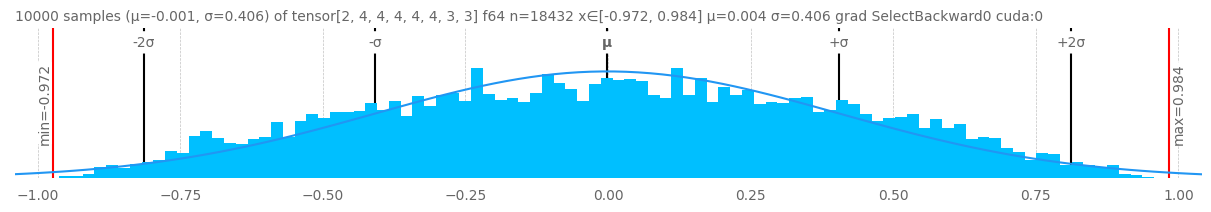

In [20]:
x0.real.plt

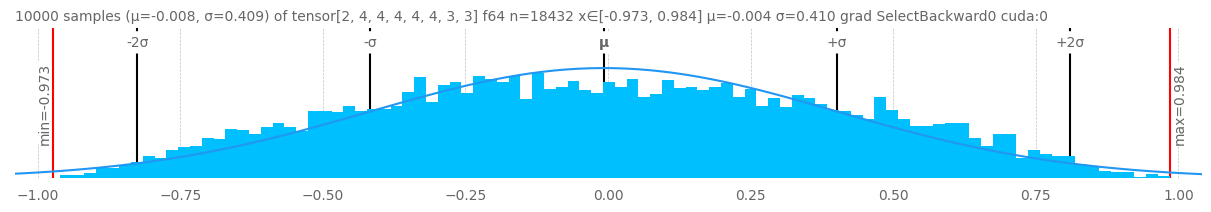

In [21]:
x0.imag.plt

### HMC

In [22]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

xhmc, history_hmc = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    eps=0.1,
    nleapfrog=4,
    job_type='hmc',
    nlog=2,
    nprint=25,
    grab=True
)

[06/09/23 16:58:01][INFO][experiment.py:58] - Running 100 steps of hmc at beta=6.0000
[06/09/23 16:58:01][INFO][experiment.py:62] - STEP: 0
[06/09/23 16:58:02][INFO][experiment.py:62] - STEP: 1
[06/09/23 16:58:02][INFO][experiment.py:62] - STEP: 2
[06/09/23 16:58:02][INFO][experiment.py:62] - STEP: 3
[06/09/23 16:58:02][INFO][experiment.py:62] - STEP: 4
[06/09/23 16:58:03][INFO][experiment.py:62] - STEP: 5
[06/09/23 16:58:03][INFO][experiment.py:62] - STEP: 6
[06/09/23 16:58:03][INFO][experiment.py:62] - STEP: 7
[06/09/23 16:58:03][INFO][experiment.py:62] - STEP: 8
[06/09/23 16:58:04][INFO][experiment.py:62] - STEP: 9
[06/09/23 16:58:04][INFO][experiment.py:62] - STEP: 10
[06/09/23 16:58:04][INFO][experiment.py:62] - STEP: 11
[06/09/23 16:58:04][INFO][experiment.py:62] - STEP: 12
[06/09/23 16:58:04][INFO][experiment.py:62] - STEP: 13
[06/09/23 16:58:05][INFO][experiment.py:62] - STEP: 14
[06/09/23 16:58:05][INFO][experiment.py:62] - STEP: 15
[06/09/23 16:58:05][INFO][experiment.py:62] 

In [23]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [24]:
plt.rcParams['figure.figsize'] = [12.4, 4.8]

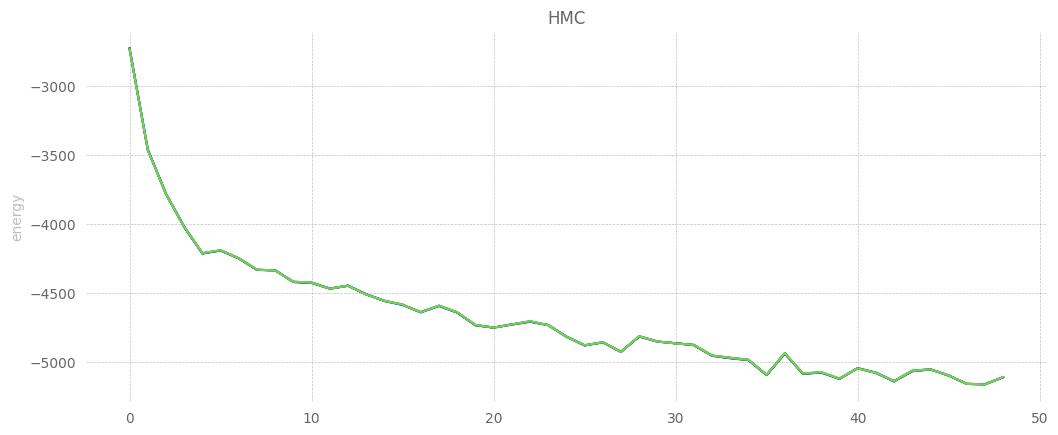

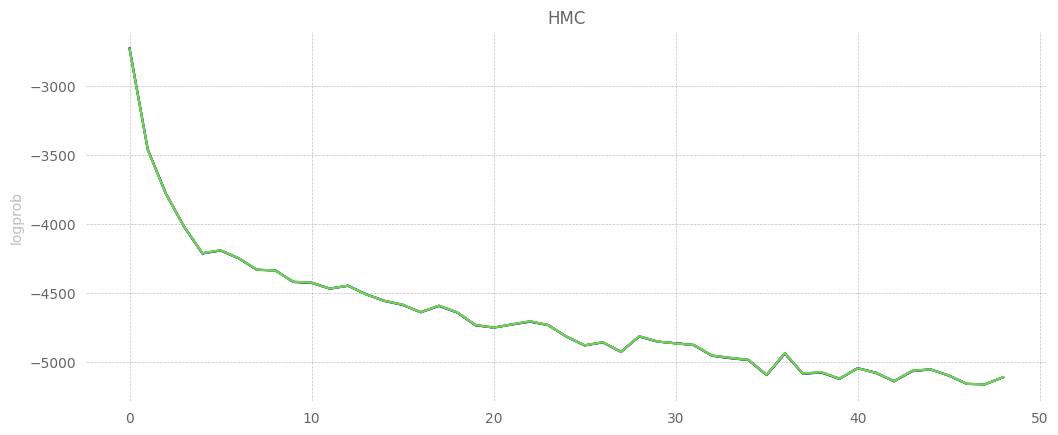

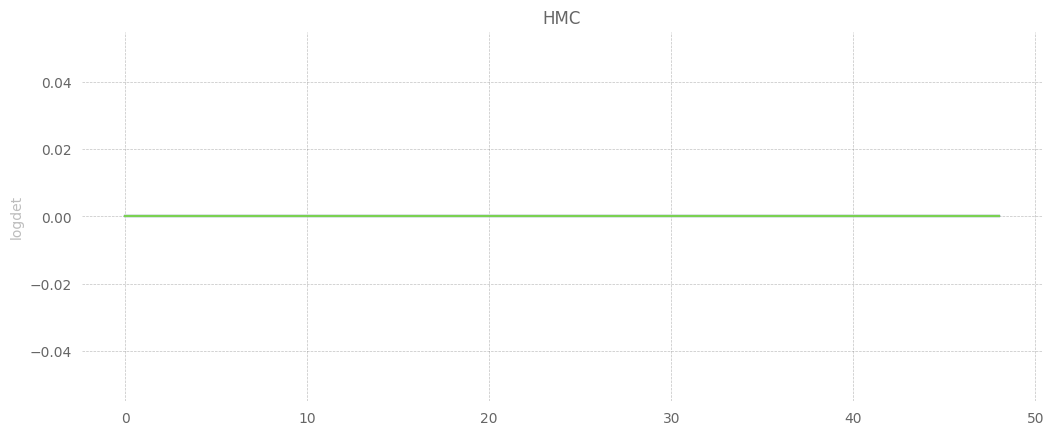

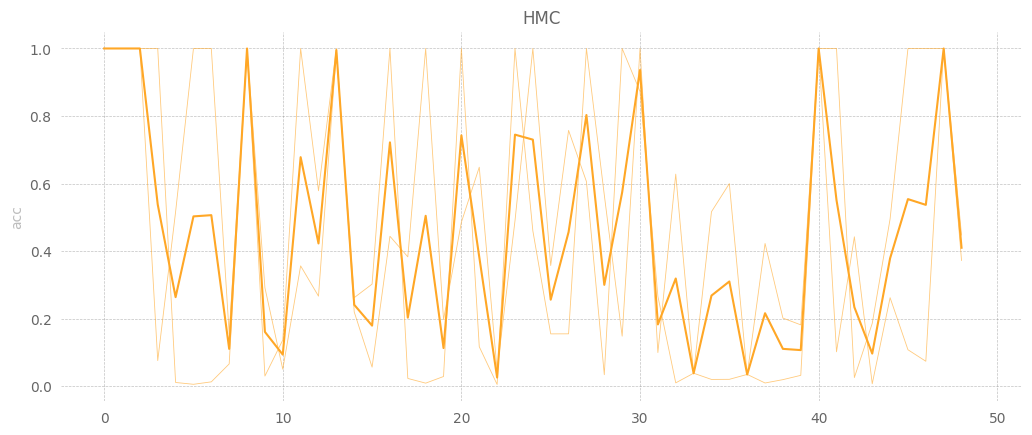

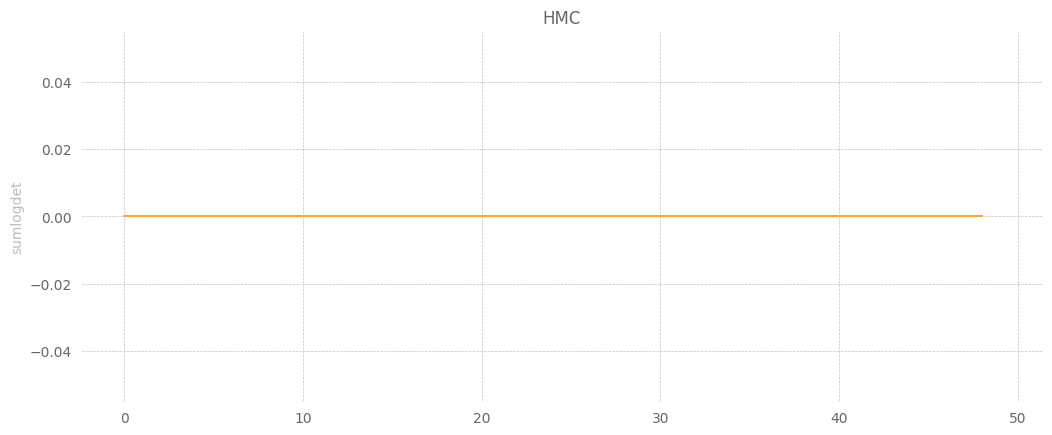

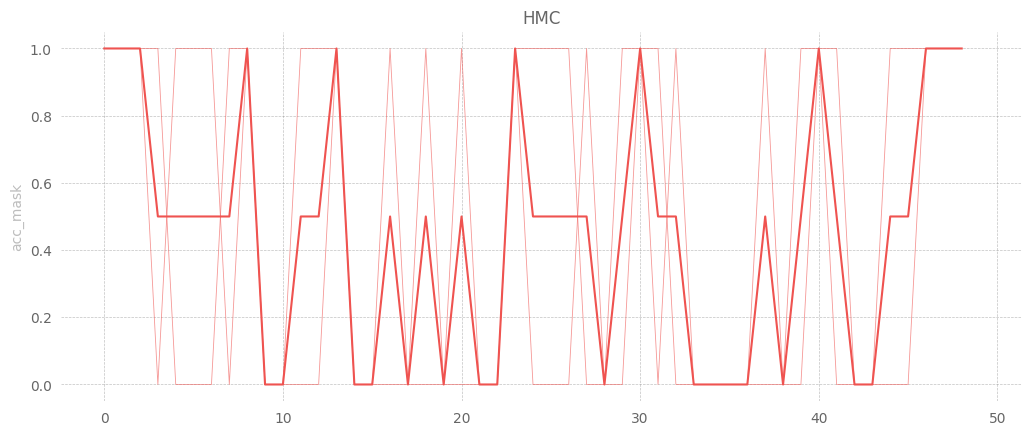

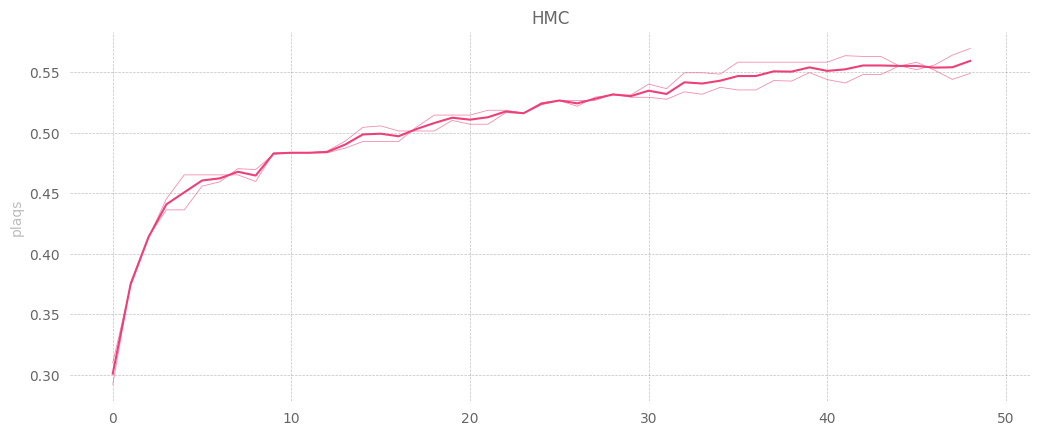

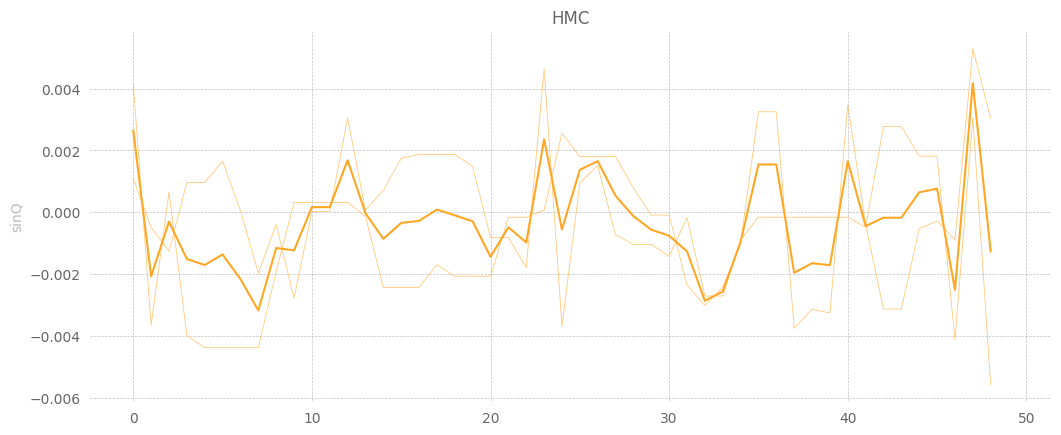

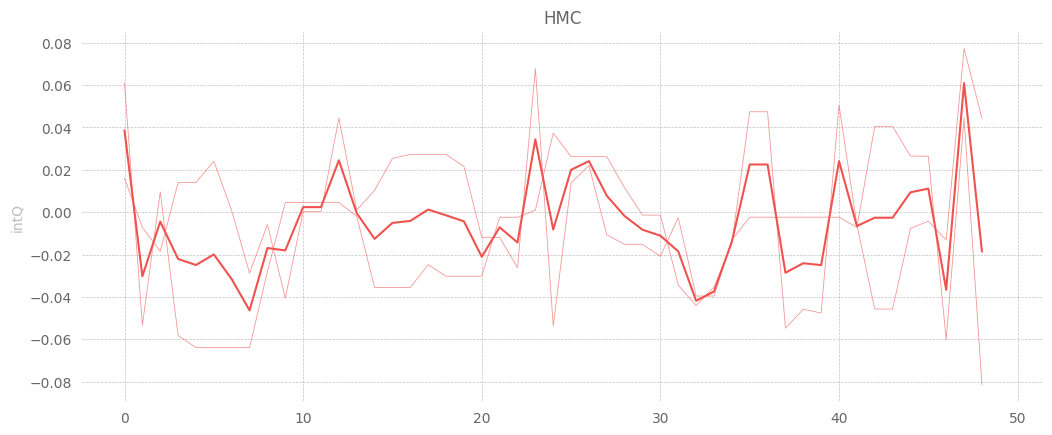

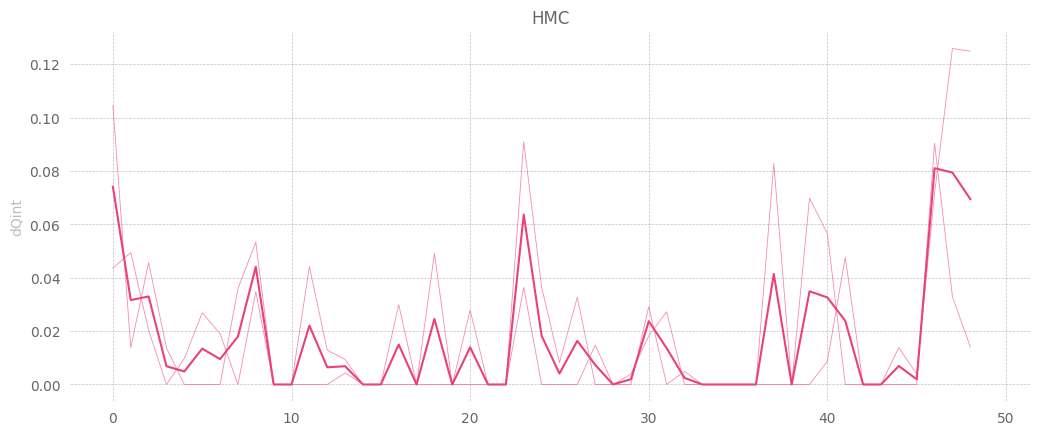

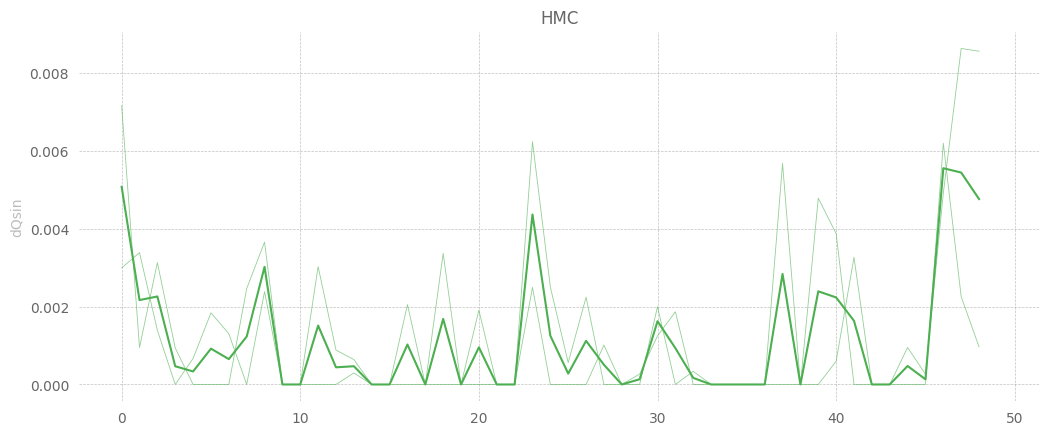

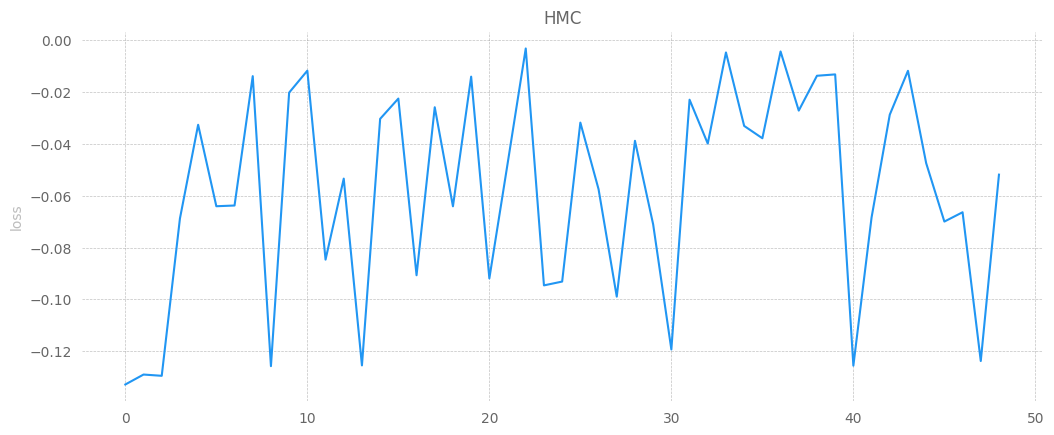

In [25]:
plot_metrics(history_hmc, title='HMC')

### Inference

In [26]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)

nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
eps = torch.tensor(0.10)

#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)

In [27]:
np.set_printoptions(precision=5)
torch.set_printoptions(precision=5)

In [28]:
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[06/09/23 17:00:43][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: None
networks.xnet.0.first.input_layer.xlayer.bias: None
networks.xnet.0.first.input_layer.vlayer.weight: None
networks.xnet.0.first.input_layer.vlayer.bias: None
networks.xnet.0.first.scale.coeff: None
networks.xnet.0.first.scale.layer.weight: None
networks.xnet.0.first.scale.layer.bias: None
networks.xnet.0.first.transf.coeff: None
networks.xnet.0.first.transf.layer.weight: None
networks.xnet.0.first.transf.layer.bias: None
networks.xnet.0.first.transl.weight: None
networks.xnet.0.first.transl.bias: None
networks.xnet.0.second.input_layer.xlayer.weight: None
networks.xnet.0.second.input_layer.xlayer.bias: None
networks.xnet.0.second.input_layer.vlayer.weight: None
networks.xnet.0.second.input_layer.vlayer.bias: None
networks.xnet.0.second.scale.coeff: None
networks.xnet.0.second.scale.layer.weight: None
networks.xnet.0.second.scale.layer.bias: None
networks.xnet.0.second.transf.coeff: None
netw

--------------------------------------------------------------------------------

WEIGHTS:

[06/09/23 17:00:43][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.998e-37, 9.999e-37] μ=1.776e-39 σ=5.764e-37 grad cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-5.050e-37]
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.999e-37, 9.999e-37] μ=-5.525e-39 σ=5.797e-37 grad cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-9.287e-37]
networks.xnet.0.first.scale.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb all_zeros grad cuda:0
networks.xnet.0.first.scale.layer.weight: Parameter containing:
Parameter[9216, 1] f64 72Kb x∈[-9.999e-37, 9.998e-37] μ=7.104e-39 σ=5.784e-37 grad cuda:0
networks.xnet.0.first.scale.layer.bias: Parameter containing:
Parameter[9216] f64 72Kb x∈[-9.997e-37, 9.995e-37] μ=4.396e-39 σ=5.774e-37 grad cuda:0

--------------------------------------------------------------------------------

In [29]:
from l2hmc.experiment.pytorch.experiment import evaluate  # noqa

#ptExpSU3.trainer.dynamics.init_weights()
#    #constant=np.random.randn() / 1e10
#    constant=0.0,
#)

xeval, history_eval = evaluate(
    nsteps=100,
    exp=ptExpSU3,
    beta=6.0,
    x=x0,
    job_type='eval',
    nlog=2,
    nprint=25,
    grab=True,
)

[06/09/23 17:00:43][INFO][experiment.py:58] - Running 100 steps of eval at beta=6.0000
[06/09/23 17:00:43][INFO][experiment.py:62] - STEP: 0
[06/09/23 17:00:44][INFO][experiment.py:62] - STEP: 1
[06/09/23 17:00:44][INFO][experiment.py:62] - STEP: 2
[06/09/23 17:00:45][INFO][experiment.py:62] - STEP: 3
[06/09/23 17:00:45][INFO][experiment.py:62] - STEP: 4
[06/09/23 17:00:45][INFO][experiment.py:62] - STEP: 5
[06/09/23 17:00:46][INFO][experiment.py:62] - STEP: 6
[06/09/23 17:00:46][INFO][experiment.py:62] - STEP: 7
[06/09/23 17:00:47][INFO][experiment.py:62] - STEP: 8
[06/09/23 17:00:47][INFO][experiment.py:62] - STEP: 9
[06/09/23 17:00:47][INFO][experiment.py:62] - STEP: 10
[06/09/23 17:00:48][INFO][experiment.py:62] - STEP: 11
[06/09/23 17:00:48][INFO][experiment.py:62] - STEP: 12
[06/09/23 17:00:48][INFO][experiment.py:62] - STEP: 13
[06/09/23 17:00:49][INFO][experiment.py:62] - STEP: 14
[06/09/23 17:00:49][INFO][experiment.py:62] - STEP: 15
[06/09/23 17:00:49][INFO][experiment.py:62]

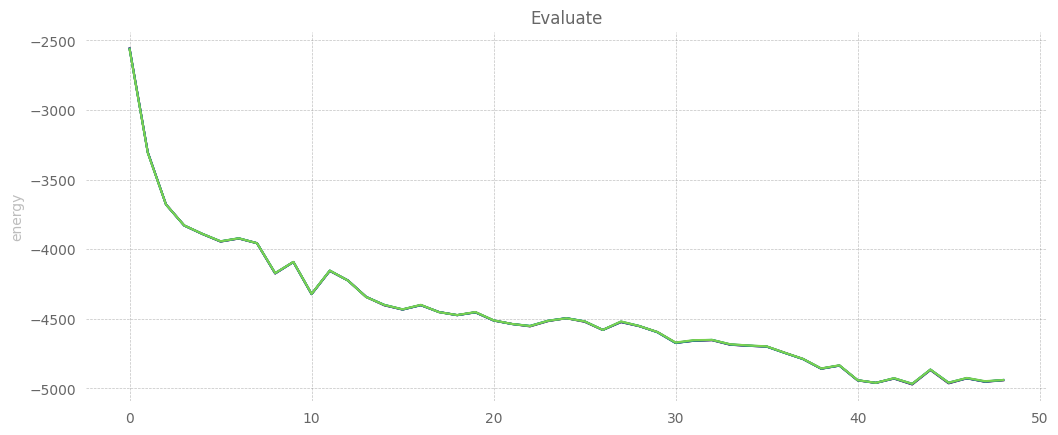

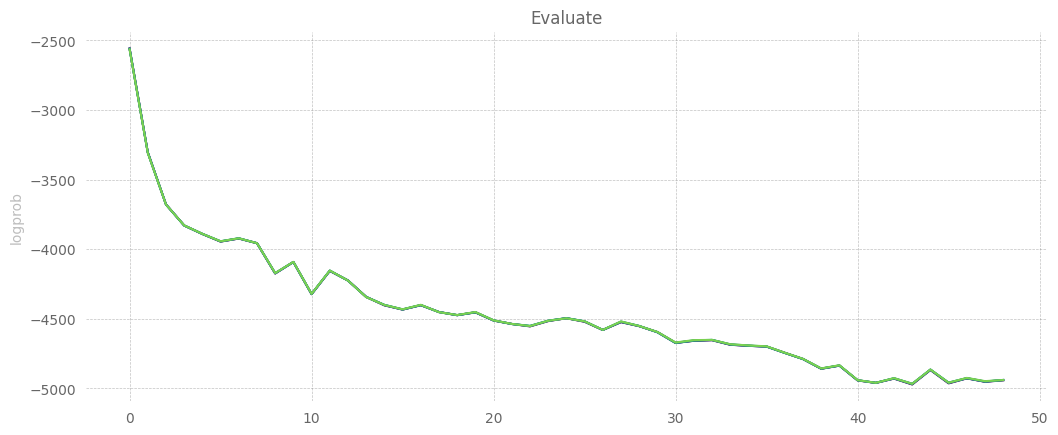

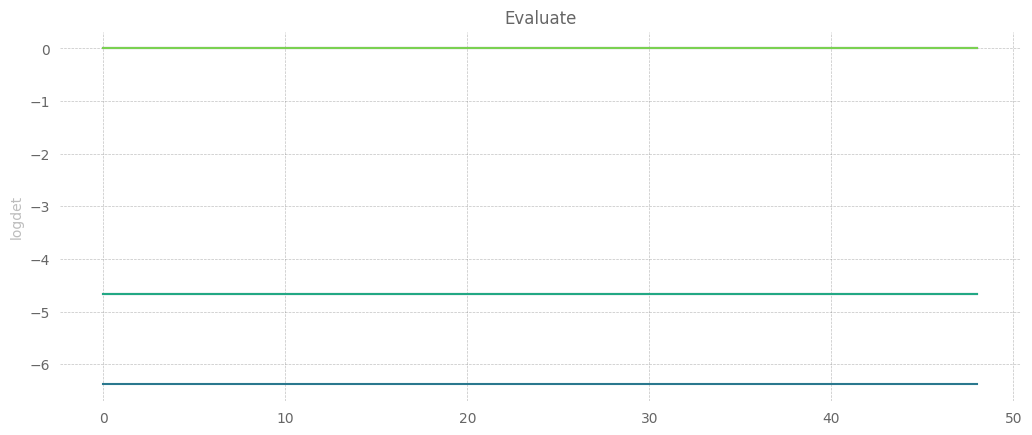

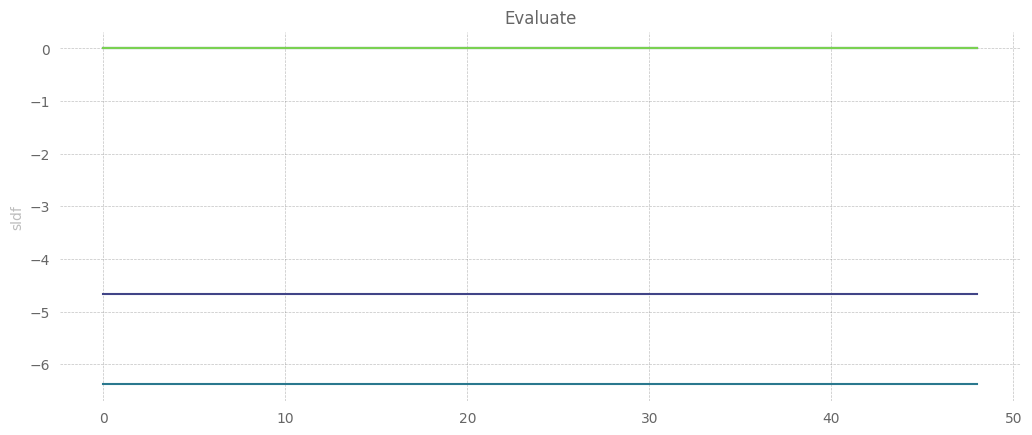

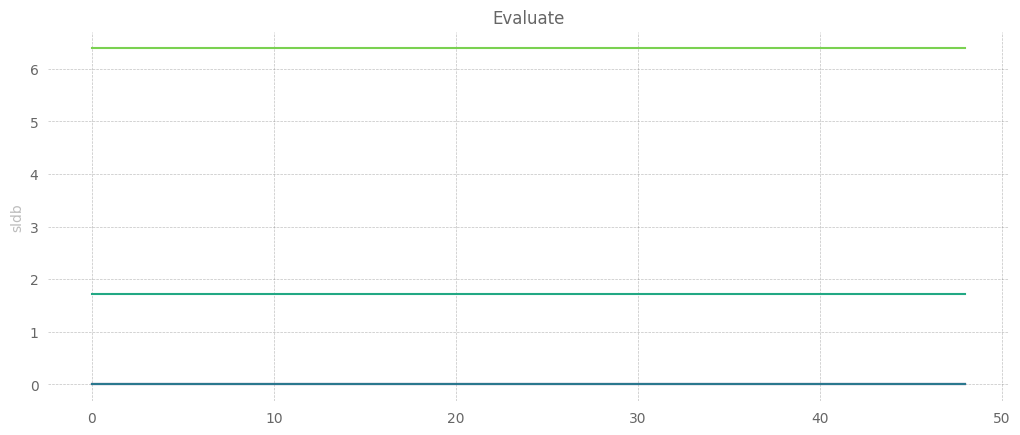

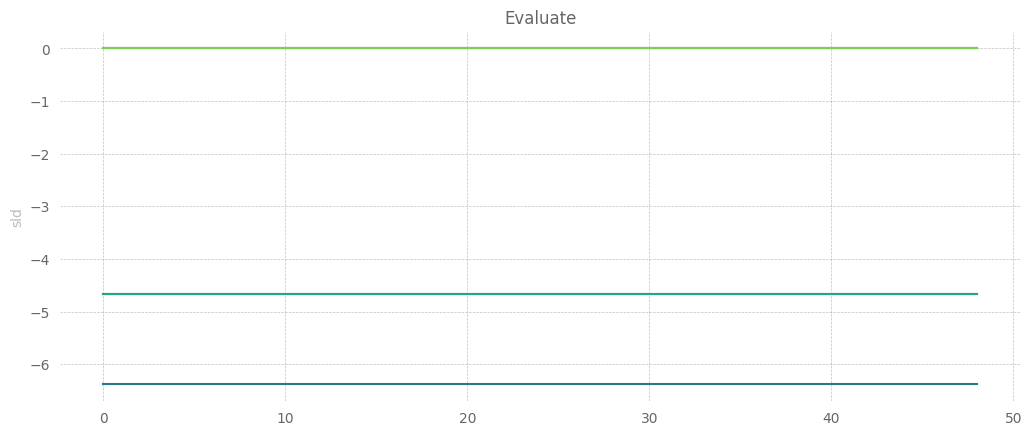

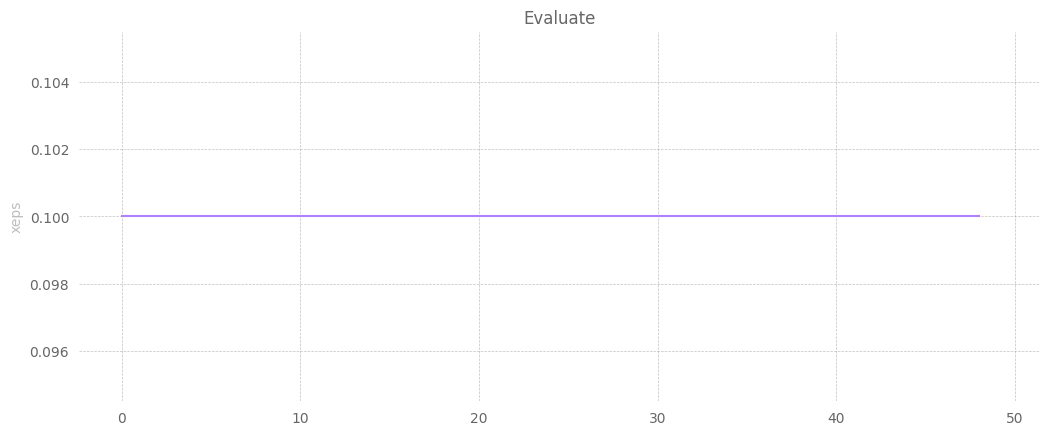

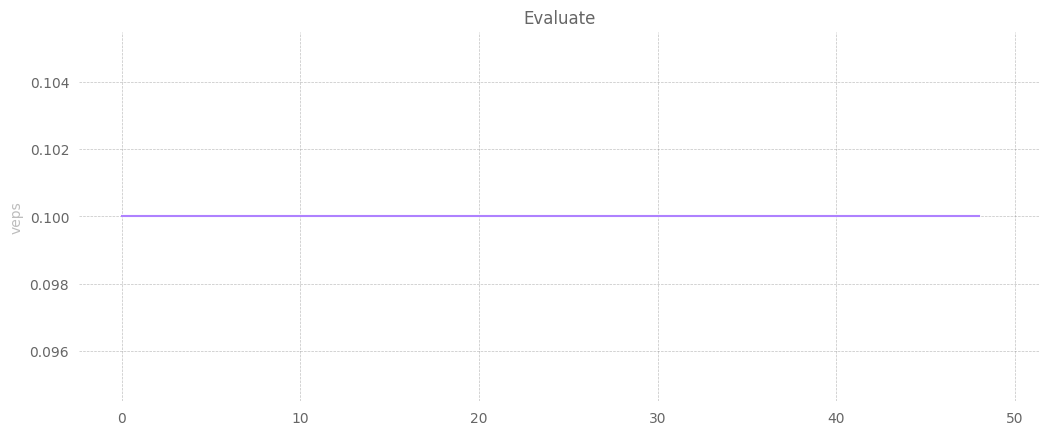

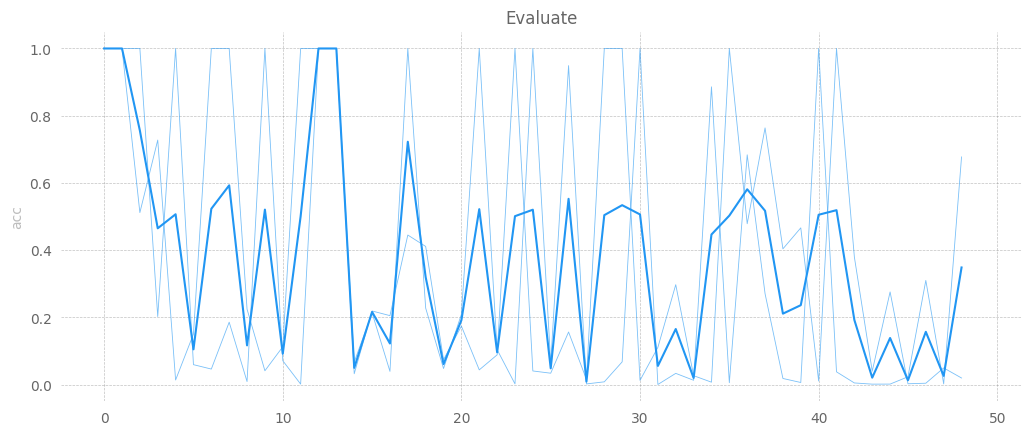

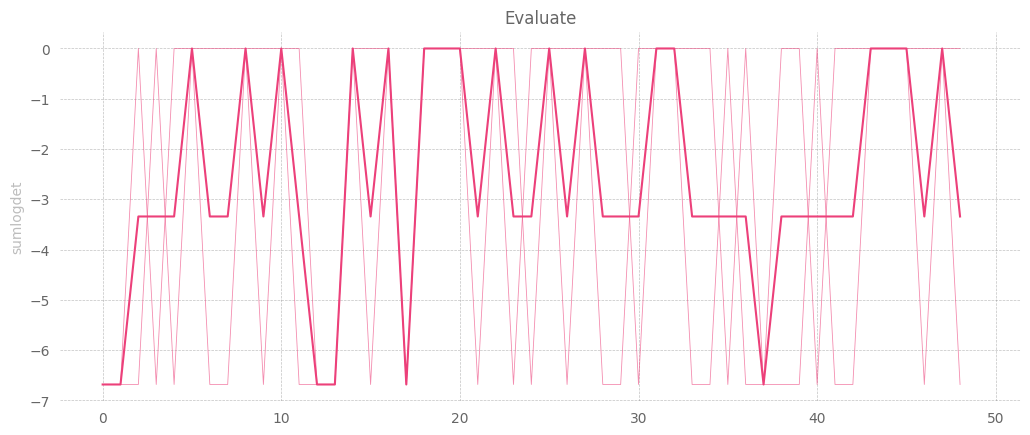

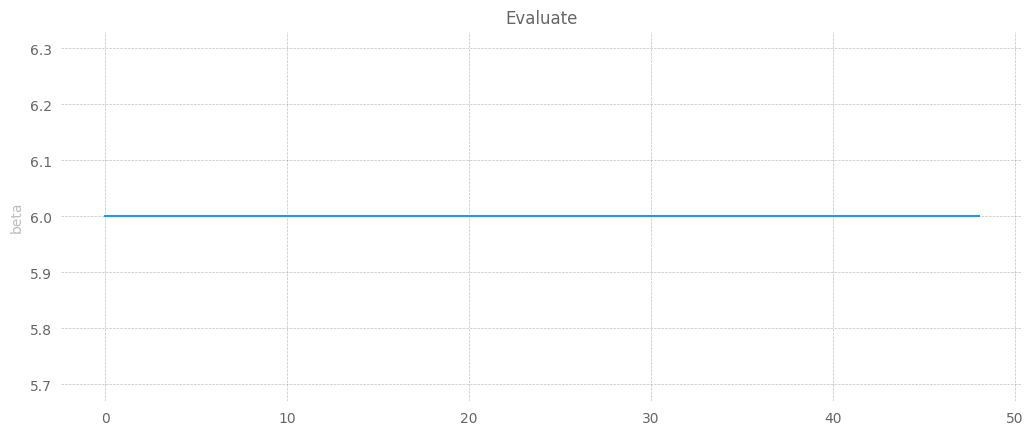

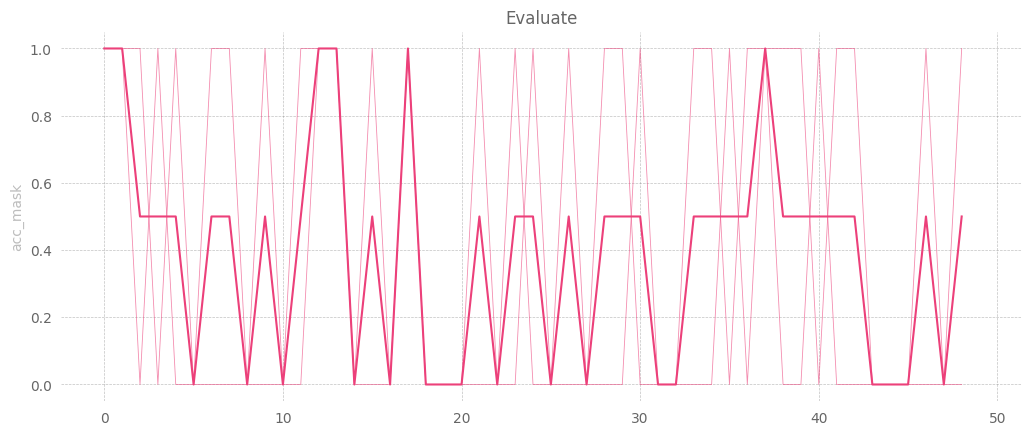

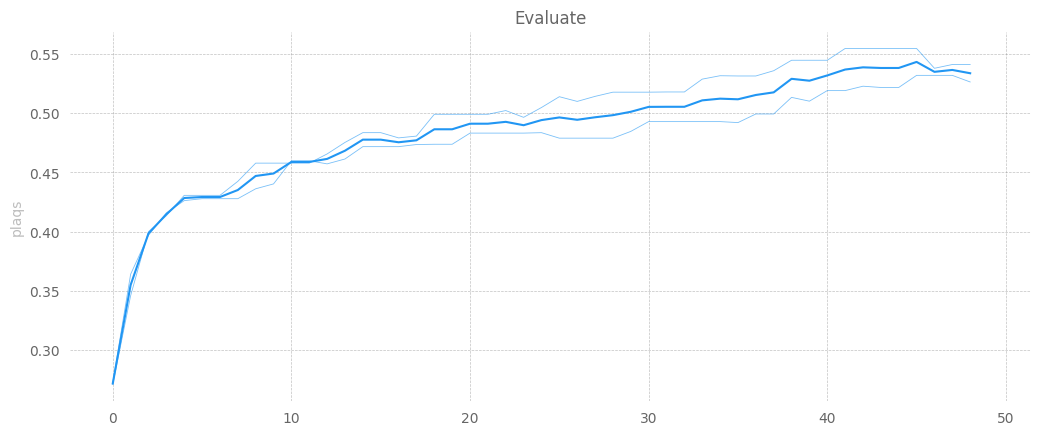

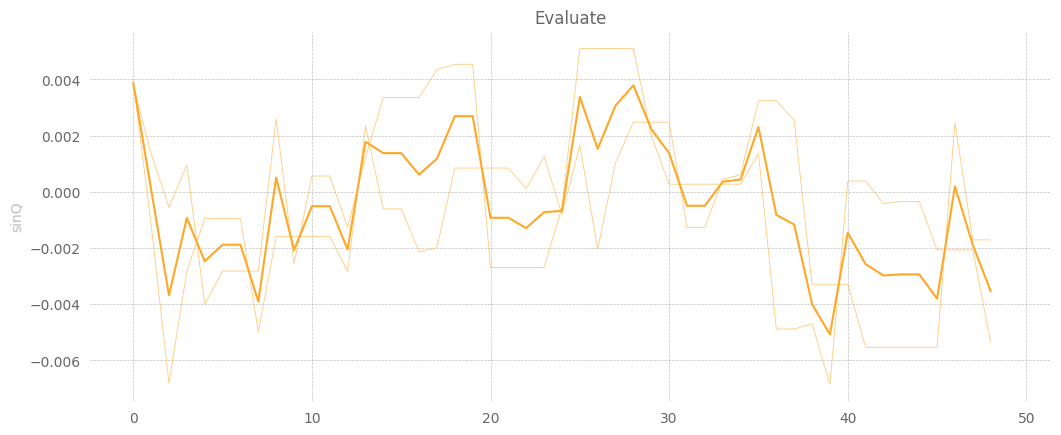

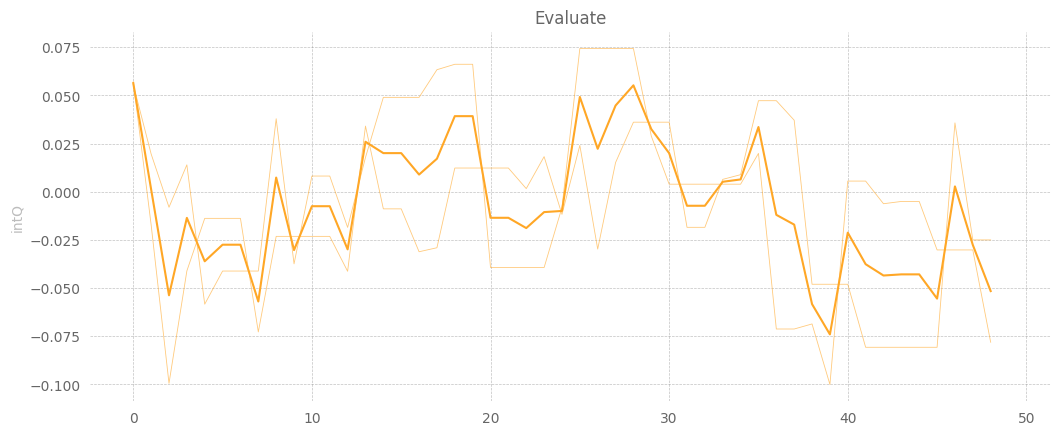

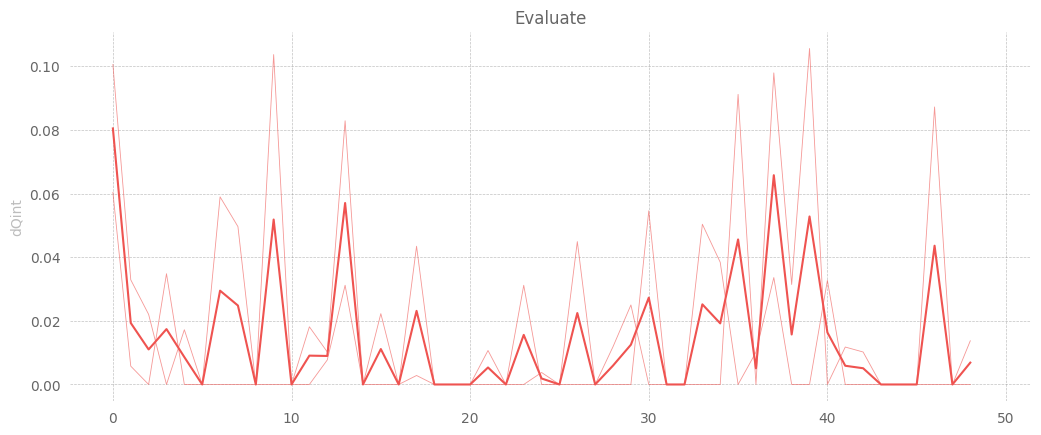

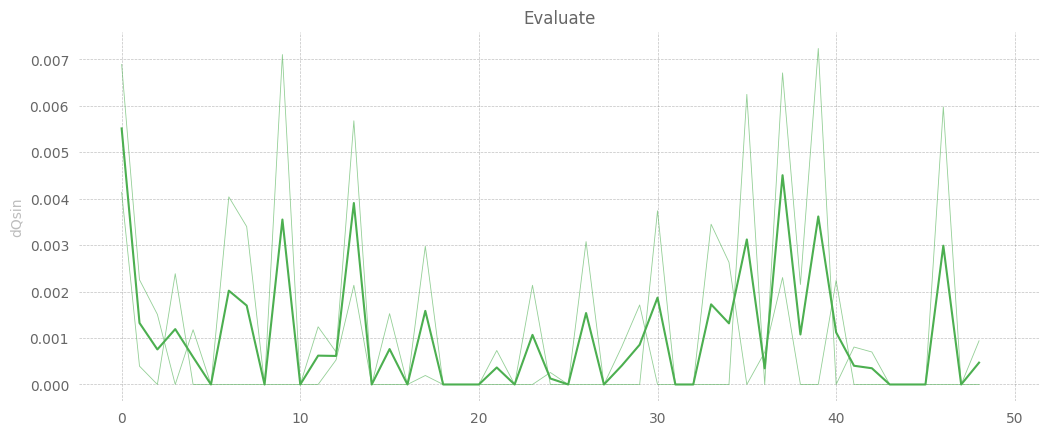

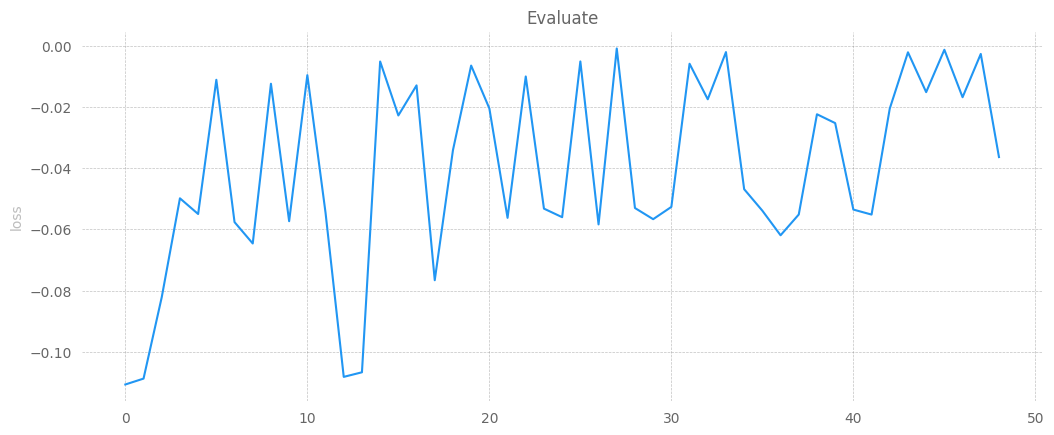

In [30]:
plot_metrics(history_eval, title='Evaluate')

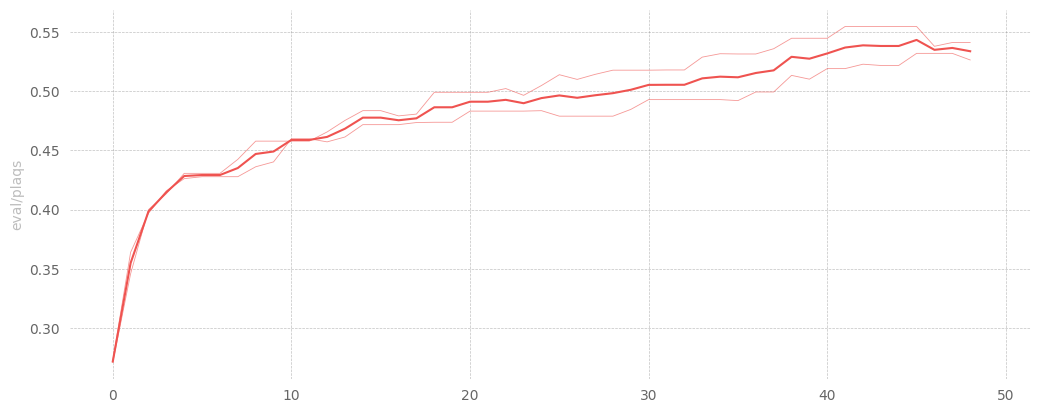

In [31]:
_ = plot_metric(history_eval['plaqs'], name='eval/plaqs')

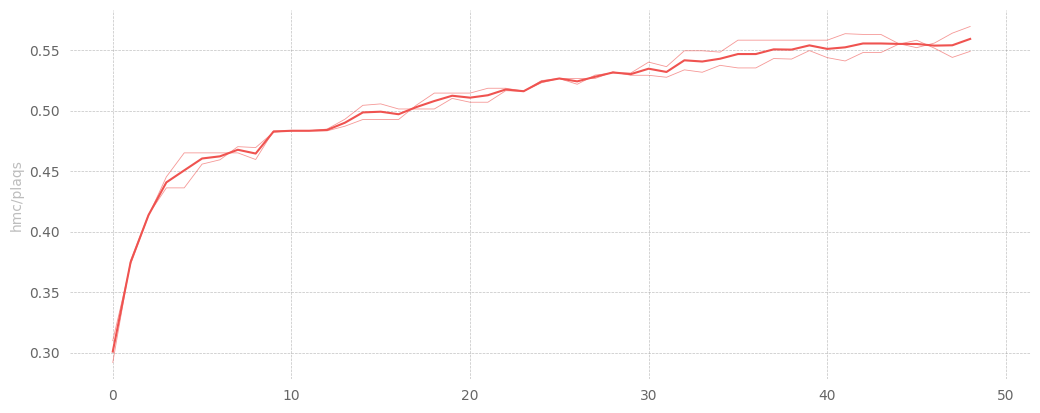

In [32]:
_ = plot_metric(history_hmc['plaqs'], name='hmc/plaqs')

In [33]:
pratio = [
    ph / pe for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]
pdiff = [
    (ph - pe).abs() for (pe, ph) in zip(history_hmc['plaqs'], history_eval['plaqs'])
]

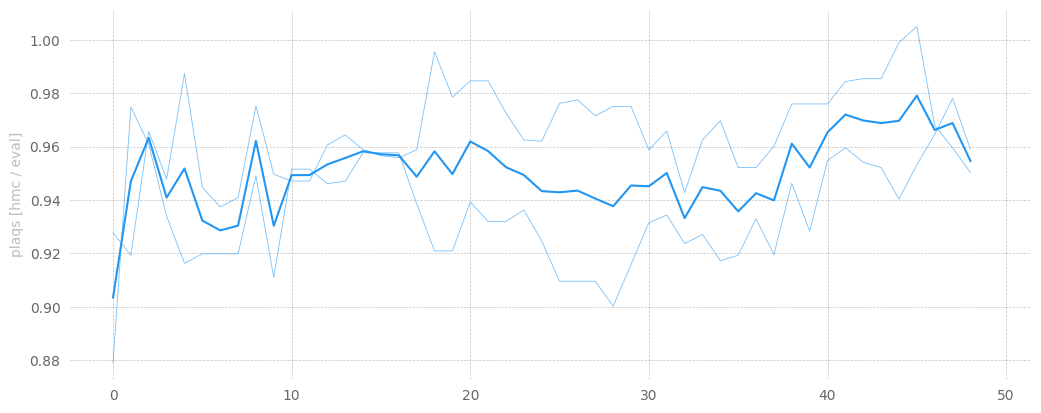

In [34]:
_ = plot_metric(pratio, name='plaqs [hmc / eval]')

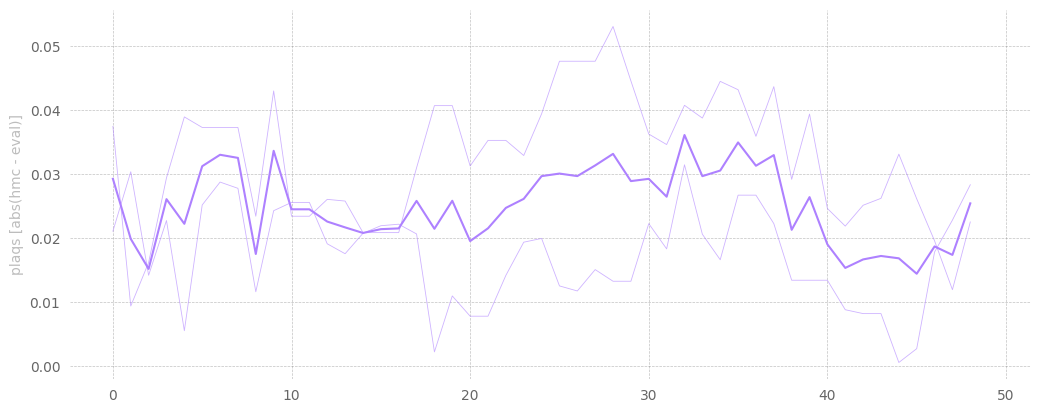

In [35]:
_ = plot_metric(pdiff, name='plaqs [abs(hmc - eval)]')

### Training

# Individual Training Step

Look at params / gradients both _before_ and _after_ a single training step

## Weights & Grads (before)

In [36]:
#ptExpSU3.trainer.dynamics.init_weights(
#    method='uniform',
#    min=-1e-36,
#    max=1e-36,
#    bias=True,
#)
#nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
#eps = torch.tensor(0.1, dtype=ptExpSU3.trainer.dynamics.xeps[0].dtype)
#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.optimizer.zero_grad()
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[06/09/23 17:04:13][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: None
networks.xnet.0.first.input_layer.xlayer.bias: None
networks.xnet.0.first.input_layer.vlayer.weight: None
networks.xnet.0.first.input_layer.vlayer.bias: None
networks.xnet.0.first.scale.coeff: None
networks.xnet.0.first.scale.layer.weight: None
networks.xnet.0.first.scale.layer.bias: None
networks.xnet.0.first.transf.coeff: None
networks.xnet.0.first.transf.layer.weight: None
networks.xnet.0.first.transf.layer.bias: None
networks.xnet.0.first.transl.weight: None
networks.xnet.0.first.transl.bias: None
networks.xnet.0.second.input_layer.xlayer.weight: None
networks.xnet.0.second.input_layer.xlayer.bias: None
networks.xnet.0.second.input_layer.vlayer.weight: None
networks.xnet.0.second.input_layer.vlayer.bias: None
networks.xnet.0.second.scale.coeff: None
networks.xnet.0.second.scale.layer.weight: None
networks.xnet.0.second.scale.layer.bias: None
networks.xnet.0.second.transf.coeff: None
netw

--------------------------------------------------------------------------------

WEIGHTS:

[06/09/23 17:04:13][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.998e-37, 9.999e-37] μ=1.776e-39 σ=5.764e-37 grad cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-5.050e-37]
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-9.999e-37, 9.999e-37] μ=-5.525e-39 σ=5.797e-37 grad cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [-9.287e-37]
networks.xnet.0.first.scale.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb all_zeros grad cuda:0
networks.xnet.0.first.scale.layer.weight: Parameter containing:
Parameter[9216, 1] f64 72Kb x∈[-9.999e-37, 9.998e-37] μ=7.104e-39 σ=5.784e-37 grad cuda:0
networks.xnet.0.first.scale.layer.bias: Parameter containing:
Parameter[9216] f64 72Kb x∈[-9.997e-37, 9.995e-37] μ=4.396e-39 σ=5.774e-37 grad cuda:0

--------------------------------------------------------------------------------

In [37]:
beta = torch.tensor(6.0)
xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)

[06/09/23 17:04:39][INFO][common.py:97] - energy: tensor[5, 2] f64 n=10 x∈[-146.057, -100.622] μ=-118.491 σ=15.138 grad StackBackward0 cuda:0 [[-109.855, -100.622], [-111.227, -101.758], [-117.787, -109.184], [-130.716, -120.955], [-146.057, -136.747]]
logprob: tensor[5, 2] f64 n=10 x∈[-146.057, -100.622] μ=-118.491 σ=15.138 grad StackBackward0 cuda:0 [[-109.855, -100.622], [-111.227, -101.758], [-117.787, -109.184], [-130.716, -120.955], [-146.057, -136.747]]
logdet: tensor[5, 2] f64 n=10 x∈[-6.386e-36, 0.] μ=-3.141e-36 σ=2.784e-36 grad StackBackward0 cuda:0 [[0., 0.], [-4.659e-36, -4.659e-36], [-6.386e-36, -6.386e-36], [-4.659e-36, -4.659e-36], [-6.682e-52, -6.682e-52]]
sldf: tensor[5, 2] f64 n=10 x∈[-6.386e-36, 0.] μ=-2.209e-36 σ=2.909e-36 grad StackBackward0 cuda:0 [[0., 0.], [-4.659e-36, -4.659e-36], [-6.386e-36, -6.386e-36], [0., 0.], [0., 0.]]
sldb: tensor[5, 2] f64 n=10 x∈[0., 6.386e-36] μ=1.623e-36 σ=2.608e-36 grad StackBackward0 cuda:0 [[0., 0.], [0., 0.], [0., 0.], [1.727e-3

## Weights & Grads (after)

<div class="alert alert-block alert-danger">
🤷🏻‍♂️ <b>nothing but <code>NaN</code>s</b>
</div>

In [38]:
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[06/09/23 17:04:44][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: tensor[1, 18432] f64 0.1Mb NaN! cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: tensor[1] f64 NaN! cuda:0 [nan]
networks.xnet.0.first.input_layer.vlayer.weight: tensor[1, 18432] f64 0.1Mb NaN! cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: tensor[1] f64 NaN! cuda:0 [nan]
networks.xnet.0.first.scale.coeff: tensor[1, 9216] f64 72Kb NaN! cuda:0
networks.xnet.0.first.scale.layer.weight: tensor[9216, 1] f64 72Kb NaN! cuda:0
networks.xnet.0.first.scale.layer.bias: tensor[9216] f64 72Kb NaN! cuda:0
networks.xnet.0.first.transf.coeff: tensor[1, 9216] f64 72Kb NaN! cuda:0
networks.xnet.0.first.transf.layer.weight: tensor[9216, 1] f64 72Kb NaN! cuda:0
networks.xnet.0.first.transf.layer.bias: tensor[9216] f64 72Kb NaN! cuda:0
networks.xnet.0.first.transl.weight: tensor[9216, 1] f64 72Kb NaN! cuda:0
networks.xnet.0.first.transl.bias: tensor[9216] f64 72Kb NaN! cuda:0
networks.xnet.0.second.input

--------------------------------------------------------------------------------

WEIGHTS:

[06/09/23 17:04:44][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb NaN! grad cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 NaN! grad cuda:0 [nan]
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb NaN! grad cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 NaN! grad cuda:0 [nan]
networks.xnet.0.first.scale.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb NaN! grad cuda:0
networks.xnet.0.first.scale.layer.weight: Parameter containing:
Parameter[9216, 1] f64 72Kb NaN! grad cuda:0
networks.xnet.0.first.scale.layer.bias: Parameter containing:
Parameter[9216] f64 72Kb NaN! grad cuda:0
networks.xnet.0.first.transf.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb NaN! grad cuda:0
networks.xnet.0.first.transf.layer.weight: Parameter containing:
Parameter[9216, 1] f6

--------------------------------------------------------------------------------

Try to re-init weights

In [40]:
ptExpSU3.trainer.optimizer.zero_grad()

In [41]:
ptExpSU3.trainer.dynamics.init_weights(
    method='uniform',
    min=-1e-36,
    max=1e-36,
    bias=True,
)
#nlf = ptExpSU3.trainer.dynamics.config.nleapfrog
#eps = torch.tensor(0.1, dtype=ptExpSU3.trainer.dynamics.xeps[0].dtype)
#ptExpSU3.trainer.dynamics.xeps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.dynamics.veps = torch.stack(
#    [
#        eps for _ in range(nlf)
#    ]
#)
#ptExpSU3.trainer.optimizer.zero_grad()
print_grads_and_weights(ptExpSU3.trainer)

--------------------------------------------------------------------------------

GRADS:

[06/09/23 17:10:45][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: None
networks.xnet.0.first.input_layer.xlayer.bias: None
networks.xnet.0.first.input_layer.vlayer.weight: None
networks.xnet.0.first.input_layer.vlayer.bias: None
networks.xnet.0.first.scale.coeff: None
networks.xnet.0.first.scale.layer.weight: None
networks.xnet.0.first.scale.layer.bias: None
networks.xnet.0.first.transf.coeff: None
networks.xnet.0.first.transf.layer.weight: None
networks.xnet.0.first.transf.layer.bias: None
networks.xnet.0.first.transl.weight: None
networks.xnet.0.first.transl.bias: None
networks.xnet.0.second.input_layer.xlayer.weight: None
networks.xnet.0.second.input_layer.xlayer.bias: None
networks.xnet.0.second.input_layer.vlayer.weight: None
networks.xnet.0.second.input_layer.vlayer.bias: None
networks.xnet.0.second.scale.coeff: None
networks.xnet.0.second.scale.layer.weight: None
networks.xnet.0.second.scale.layer.bias: None
networks.xnet.0.second.transf.coeff: None
netw

--------------------------------------------------------------------------------

WEIGHTS:

[06/09/23 17:10:45][INFO][common.py:97] - networks.xnet.0.first.input_layer.xlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-1.000e-36, 9.997e-37] μ=2.217e-39 σ=5.770e-37 grad cuda:0
networks.xnet.0.first.input_layer.xlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [3.392e-37]
networks.xnet.0.first.input_layer.vlayer.weight: Parameter containing:
Parameter[1, 18432] f64 0.1Mb x∈[-1.000e-36, 1.000e-36] μ=3.217e-39 σ=5.782e-37 grad cuda:0
networks.xnet.0.first.input_layer.vlayer.bias: Parameter containing:
Parameter[1] f64 grad cuda:0 [4.470e-37]
networks.xnet.0.first.scale.coeff: Parameter containing:
Parameter[1, 9216] f64 72Kb NaN! grad cuda:0
networks.xnet.0.first.scale.layer.weight: Parameter containing:
Parameter[9216, 1] f64 72Kb x∈[-9.999e-37, 1.000e-36] μ=-6.620e-39 σ=5.752e-37 grad cuda:0
networks.xnet.0.first.scale.layer.bias: Parameter containing:
Parameter[9216] f64 72Kb x∈[-9.995e-37, 9.999e-37] μ=3.244e-39 σ=5.826e-37 grad cuda:0
networ

--------------------------------------------------------------------------------

In [45]:
from torch import autograd

#with autograd.detect_anomaly(check_nan=True):
#    xout, metrics = train_step(x=x0, beta=beta, trainer=ptExpSU3.trainer)


state = ptExpSU3.trainer.dynamics.random_state(beta=6.0)
x = state.x
beta = state.beta
ptExpSU3.trainer.optimizer.zero_grad(set_to_none=False)

with autograd.detect_anomaly(check_nan=True):
    xout, metrics = ptExpSU3.trainer.dynamics((x, beta))
    xprop = metrics.pop('mc_states').proposed.x
    loss = calc_loss(x, xprop, metrics['acc'])
    #import pdb ; pdb.set_trace()
    loss.backward()
    torch.nn.utils.clip_grad.clip_grad_norm(
        trainer.dynamics.parameters(),
        max_norm=float(1e-16),
    )
    ptExpSU3.trainer.optimizer.step()
    metrics |= {'loss': loss.item()}
    print_dict(metrics, grab=False)

RuntimeError: Function 'BmmBackward0' returned nan values in its 0th output.